In [1]:
import numpy as np
import pandas as pd
from copy import copy

In [2]:
import terminal_optimization.visualisation        as visualisation
import terminal_optimization.forecast             as forecast
import terminal_optimization.investment_decisions as invest
import terminal_optimization.infrastructure       as infra
import terminal_optimization.financial_analysis   as financial
import terminal_optimization.initial_terminal     as initial

# 1 Scenario Generator

In [3]:
def scenario_generator(start_year, simulation_window):
    
    # Import commodities from package
    maize   = forecast.bulk_commodities(**forecast.maize_data)
    soybean = forecast.bulk_commodities(**forecast.maize_data)
    wheat   = forecast.bulk_commodities(**forecast.wheat_data)

    # Maize - Linear demand
    demand_maize  = 1000000        # demand at t=0
    growth_maize  = 100000       

    # Soybean - Exponential demand
    demand_soybean = 1000000
    rate_soybean   = 1.06          # year on year growth rate of demand (% points) - input for constant method and random method

    # Wheat - Probabilistic demand
    demand_wheat   = 1000000
    rate_wheat     = 1.05
    mu_wheat       = 0.01          # avg bonus rate added to base rate (% points)  - input for random method
    sigma_wheat    = 0.015         # standard deviation of bonus rate (% points)   - input for random method

    # Create forecast
    maize.linear_forecast(start_year, simulation_window, demand_maize, growth_maize)
    soybean.exponential_forecast(start_year, simulation_window, demand_soybean, rate_soybean)
    wheat.random_forecast(start_year, simulation_window, demand_wheat, rate_wheat, mu_wheat, sigma_wheat)
    commodities = [maize, soybean, wheat]
    
    
    # Import vessels from package
    handysize = forecast.vessel(**forecast.handysize_data)
    handymax  = forecast.vessel(**forecast.handymax_data)
    panamax   = forecast.vessel(**forecast.panamax_data)
    vessels = [handysize, handymax, panamax]
    
    # Calculate yearly calls
    vessels = forecast.vessel_call_calc(vessels, commodities, simulation_window)

    # Plot forecast
    visualisation.trend(commodities, simulation_window, start_year)
    
    return vessels, commodities

# 2 Simulator

In [4]:
def simulate(terminal, occupancy_trigger, vessels, commodities, start_year, simulation_window):
    
    for i in range (start_year, start_year + simulation_window):
        year = i 
        timestep = year - start_year

        ######################
        # Investment Decisions
        ######################           
        
        # Berths and cranes
        allowable_berth_occupancy = occupancy_trigger
        terminal.berths, terminal.cranes = invest.berth_invest_decision(terminal.berths, terminal.cranes, vessels, allowable_berth_occupancy, year, timestep, operational_hours)
        
        # Quay
        terminal.quays = invest.quay_invest_decision(terminal.quays, terminal.berths, year, timestep)

        # Storage
        storage_type            = 'Silos'
        trigger_throughput_perc = 10  # Percentage of annual throughput which triggers the investment in a new storage unit
        aspired_throughput_perc = 20  # Aspired of annual throughput which is realised due to the new storage unit
        terminal.storage = invest.storage_invest_decision(terminal.storage, trigger_throughput_perc, aspired_throughput_perc, storage_type, commodities, year, timestep)

        # Loading stations
        station_utilisation     = 0.60 # Loading station utilisation
        trigger_throughput_perc = 80   # Percentage of hourly peak demand which triggers the investment in a new loading unit
        aspired_throughput_perc = 120  # Aspired percentage of hourly peak demand which is realised due to the new loading unit
        terminal.stations = invest.station_invest_decision(terminal.stations, station_utilisation, trigger_throughput_perc, aspired_throughput_perc, commodities, year, timestep, operational_hours)

        # Conveyors
        terminal.quay_conveyors = invest.quay_conveyor_invest_decision(terminal.quay_conveyors, terminal.cranes, year, timestep, operational_hours)
        terminal.hinterland_conveyors = invest.hinterland_conveyor_invest_decision(terminal.hinterland_conveyors, terminal.stations, year, timestep, operational_hours)

        ######################
        # Business Logic
        ######################

        # Terminal throughput
        terminal = financial.throughput_calc(terminal, vessels, commodities, allowable_berth_occupancy, year, timestep, operational_hours)
        # Revenues
        terminal.revenues = financial.revenue_calc(terminal.revenues, terminal.throughputs, commodities, year, timestep)
        # Capex
        terminal.capex = financial.capex_calc(terminal, year, timestep)
        # Labour costs
        terminal.labour = financial.labour_calc(terminal, year, timestep, operational_hours)
        # Maintenance costs
        terminal.maintenance = financial.maintenance_calc(terminal, year, timestep)
        # Energy costs
        terminal.energy = financial.energy_calc(terminal, year, operational_hours, timestep)
        # Insurance costs
        terminal.insurance = financial.insurance_calc(terminal, year, timestep)
        # Lease costs 
        terminal.lease = financial.lease_calc(terminal, year,timestep)
        # Demurrage costs
        terminal.demurrage = financial.demurrage_calc(terminal.demurrage, terminal.berths, vessels, year, timestep)
        # Residual value calculations 
        terminal.residuals = financial.residual_calc(terminal, year, timestep)
        # Profits
        terminal.profits = financial.profit_calc(terminal, simulation_window, timestep, year, start_year)
        # Opex
        terminal.opex = financial.opex_calc(terminal, year, timestep)
    
    # Combine all cashflows
    terminal.cashflows = financial.cashflow_calc(terminal, simulation_window, start_year)       
        
    #WACC depreciated profits
    terminal.WACC_cashflows = financial.WACC_calc(terminal.profits, simulation_window, start_year)

    #NPV 
    terminal.NPV = financial.NPV_calc(terminal.WACC_cashflows)
    
    print ('Simulation complete')
            
    return terminal

# Single Simulation Run

Simulation complete


C:\Python\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


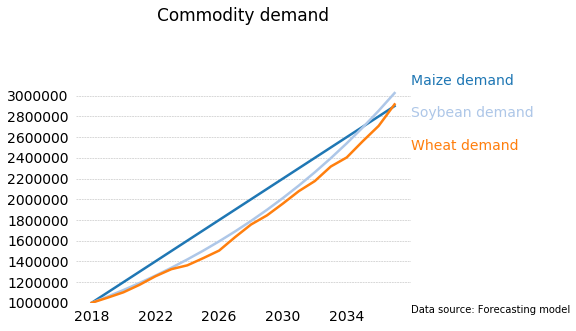

In [5]:
# Simulation parameters
start_year        = 2018   # start year of simulation
simulation_window = 20     # forecast 20 years
end_year          = start_year + simulation_window - 1
operational_hours = 4680   # operational hours per year
allowable_occupancy = 0.40

# Run scenario generator
vessels, commodities = scenario_generator(start_year, simulation_window)

# Import existing terminal infrastructure 
terminal = initial.terminal()

# Run simulation
terminal = simulate(terminal, allowable_occupancy, vessels, commodities, start_year, simulation_window)

# 4 Preliminary Plots

### Demand vs. Capacity

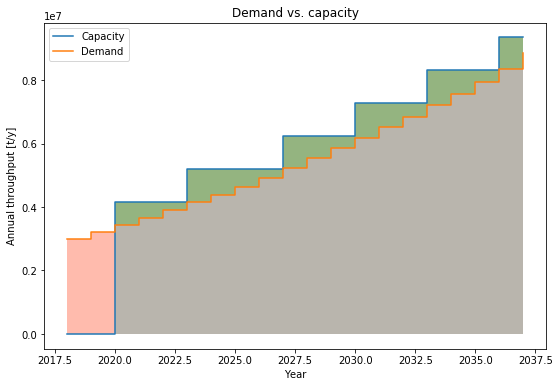

In [6]:
# Plotting capacity vs. demand 
visualisation.throughput(terminal, 9,6)

C:\Python\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Python\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


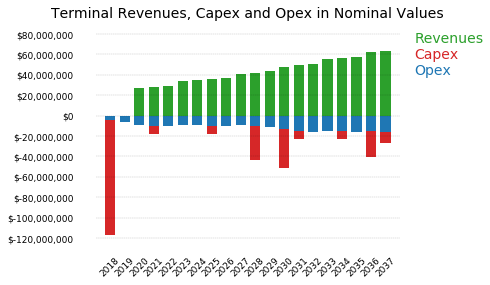

In [7]:
visualisation.revenue_capex_opex(terminal)

### Profit / Loss (nominal)

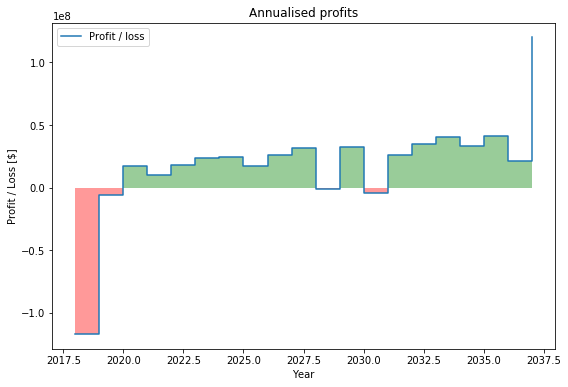

In [8]:
# Plotting annualised profits
visualisation.profit_loss(terminal.profits, 9, 6)

### Profit / Loss (present value)

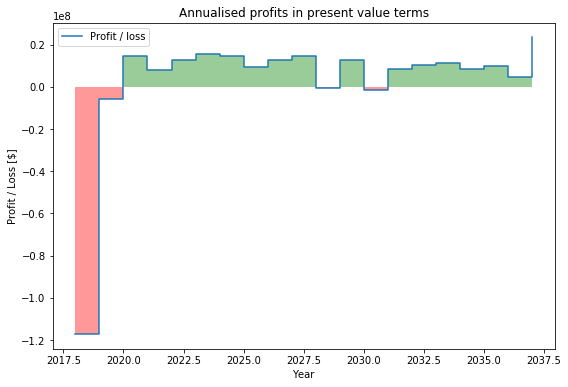

In [9]:
# Plotting annualised profits
visualisation.profit_loss_pv(terminal.WACC_cashflows, 9, 6)

C:\Python\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


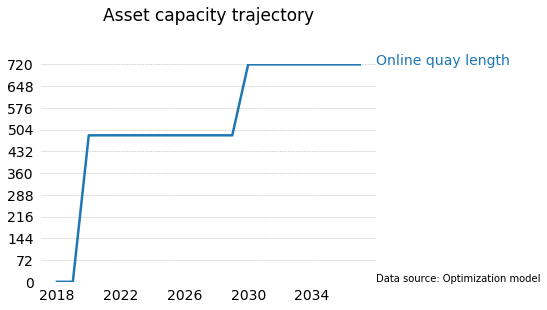

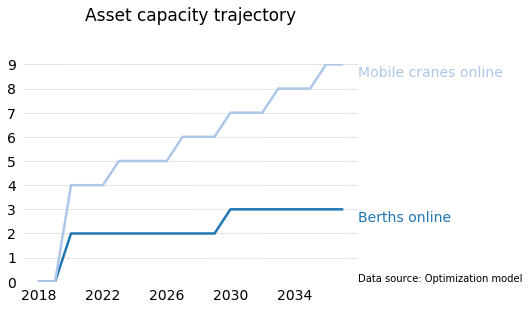

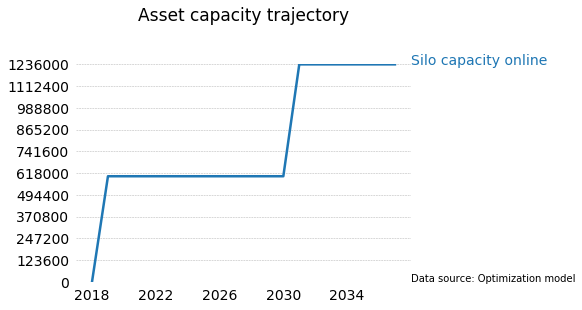

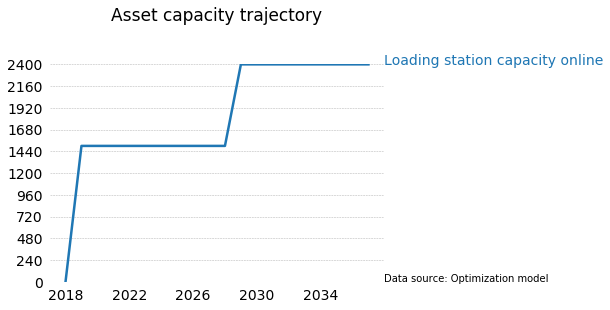

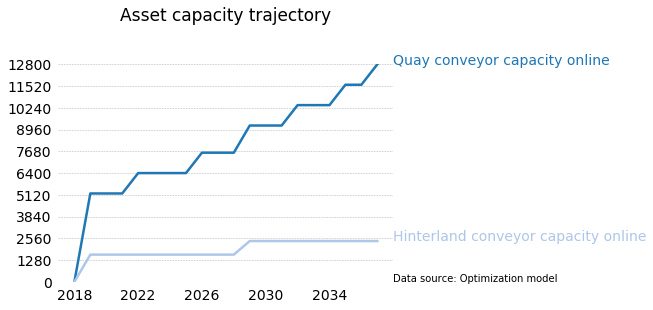

In [10]:
visualisation.asset_trajectory(terminal, simulation_window, start_year)

# 5 Iterate through invest decisions

In [12]:
# Run multiple simulations, each with a different allowable berth occupancy between 20% and 95%
iterations = []

occupancy_spectrum = range (20, 96, 5)
for occupancy in occupancy_spectrum:
    
    # The trigger occupancy
    trigger_occupancy = occupancy/100
    
    # Load the initial terminal setup
    terminal = initial.terminal()
    
    # Run simulation
    terminal = simulate(terminal, allowable_occupancy, vessels, commodities, start_year, simulation_window)
    
    # Save resulting terminal 
    iterations.append(terminal)

Simulation complete
Simulation complete
Simulation complete
Simulation complete
Simulation complete
Simulation complete
Simulation complete
Simulation complete
Simulation complete
Simulation complete
Simulation complete
Simulation complete
Simulation complete
Simulation complete
Simulation complete
Simulation complete


In [13]:
NPV_collection = []
for i in range (len(iterations)):
    single_NPV = iterations[i].NPV
    NPV_collection.append(single_NPV)

In [14]:
NPV_collection

['$65,592,420',
 '$65,592,420',
 '$65,592,420',
 '$65,592,420',
 '$65,592,420',
 '$65,592,420',
 '$65,592,420',
 '$65,592,420',
 '$65,592,420',
 '$65,592,420',
 '$65,592,420',
 '$65,592,420',
 '$65,592,420',
 '$65,592,420',
 '$65,592,420',
 '$65,592,420']

In [15]:
terminal.cashflows

,Year,Profits,Revenues,Capex,Opex,Labour costs,Maintenance costs,Energy costs,Insurance costs,Lease costs,Demurrage costs,Residual asset value
0,2018,-117131460,0,-112325560,-4805900,1633600,3172300,0,0,0,0,0
1,2019,-6210149,0,0,-6210149,1633600,3172300,780249,624000,0,0,62400000
2,2020,17468783,26862311,0,-9393527,1633600,3490925,864591,1261250,0,2143161,103922560
3,2021,10042437,27798267,-7453750,-10302079,1874800,3954000,870617,1261250,0,2341412,98980308
4,2022,18124329,28748380,0,-10624050,1874800,3954000,911646,1297250,0,2586354,97638057
5,2023,23847112,33345929,0,-9498816,1874800,3954000,893494,1297250,0,1479272,95660806
6,2024,24692776,34326956,0,-9634179,1874800,3954000,898984,1297250,0,1609145,90192305
7,2025,17359471,35324845,-7453750,-10511623,2116000,4417075,906952,1297250,0,1774346,84723804
8,2026,25633177,36340608,0,-10707430,2116000,4417075,947661,1333250,0,1893444,82855301
9,2027,31235069,41007746,0,-9772676,2116000,4417075,931754,1333250,0,974597,80351800
